In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Custom module to create synthetic dataset
from utils.sine_dataset import signal_dataset_creator


In [7]:
# LSTM parameters
hidden_dim = 20
n_signals = 1
N = 64
tagset_size = 1


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cpu


In [8]:
# Model creation
class LSTM60Hz(nn.Module):
    """Some Information about LSTM60Hz"""

    def __init__(self, N, hidden_dim, tagset_size):
        super(LSTM60Hz, self).__init__()
        self.lstm = nn.LSTM(N, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_layer = self.fc(lstm_out[:, -1, :])

        return torch.sigmoid(fc_layer)


model = LSTM60Hz(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
print(f"Model structure: {model}\n")

Model structure: LSTM60Hz(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)



In [9]:
# Define Dataset Class
class SineWaveDataset(torch.utils.data.Dataset):
    """Some Information about SineWaveDataset"""

    def __init__(self, signals, labels, transform=None, labels_transform=None):
        super(SineWaveDataset, self).__init__()
        self.signals = signals
        self.labels = labels
        self.transform = transform
        self.labels_transform = labels_transform

    def __getitem__(self, index):
        signal = self.signals[index]
        label = self.labels[index]
        if self.transform:
            signal = self.transform(signal)
        if self.labels_transform:
            label = self.labels_transform(label)
        return signal, label

    def __len__(self):
        return len(self.signals)


In [21]:
# Dataset Parameters
fs = 3840
N = 64
m = 2000

# Create Dataset Signals
signals, target = signal_dataset_creator(fs, N, m)
signals = np.expand_dims(signals, axis=2)
signals = torch.from_numpy(signals).float()
target = torch.from_numpy(target).float()

# Create Dataset instance

dataset = SineWaveDataset(signals, target)
train_dataset, test_dataset, val_dataset = random_split(dataset, [0.9, 0.09, 0.01])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)


In [18]:
# Create Training / Test / Validation Loop

# Training
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )


In [22]:
CUDA_LAUNCH_BLOCKING = 1
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-----------------------------------
loss: 0.221262  [    0/ 1800]
loss: 0.132301  [  160/ 1800]
loss: 0.182799  [  320/ 1800]
loss: 0.346726  [  480/ 1800]
loss: 0.212577  [  640/ 1800]
loss: 0.051063  [  800/ 1800]
loss: 0.073808  [  960/ 1800]
loss: 0.102020  [ 1120/ 1800]
loss: 0.237001  [ 1280/ 1800]
loss: 0.228149  [ 1440/ 1800]
loss: 0.034468  [ 1600/ 1800]
loss: 0.226497  [ 1760/ 1800]
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.056754 

Done!


tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.]])
torch.Size([16, 64, 1])
tensor([[0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)


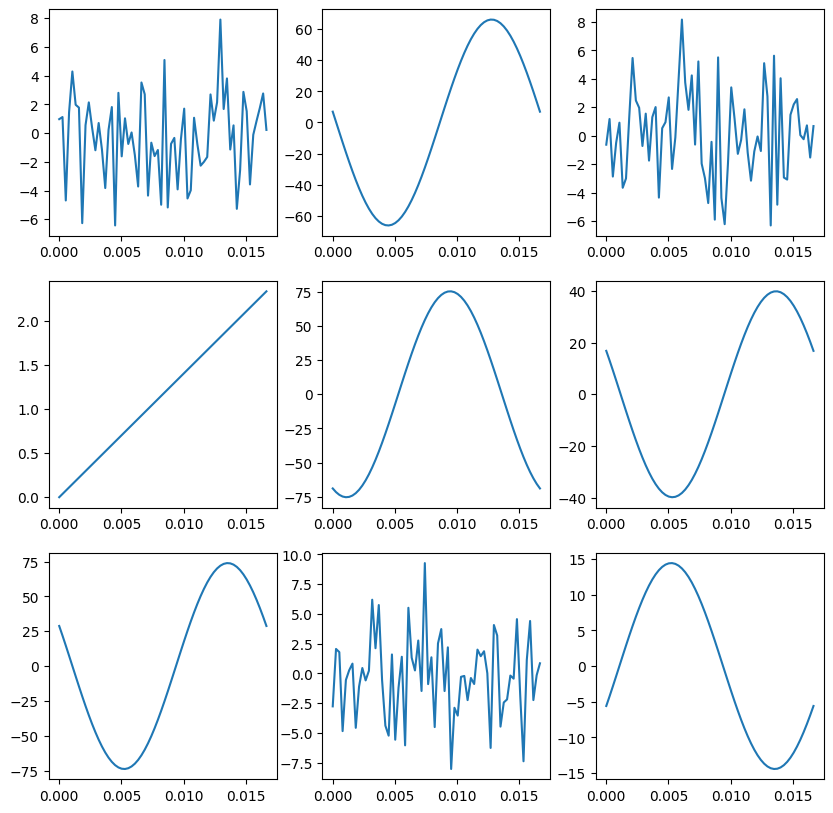

In [23]:
dataiter = iter(val_dataloader)
signal, labels = next(dataiter)

t = np.linspace(0,N/fs,N)
print(labels[1:10])
print(signal.shape)
figure = plt.figure(figsize=(10,10))
cols, rows = 3, 3
for i in range(1, cols * rows +1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t,signal[i,:,0])
x = model(signal[1:10].to(device))
print(torch.round(x))


In [31]:
# Para escoger probar con señales generadas por fuera del dataset
from utils.sine_dataset import (
    sine_phase_creator,
    sine_creator,
    gaussian_creator,
    constant_creator,
    sine_noise,
)

fs = 3840
N = 64
m = 100
t = np.linspace(0, N / fs, N)
signals_prueba = t
target = np.array([0])

# Crear datos con magnitudes en el orden de 10k - 10M
# para probar si el modelo generaliza (entrenado con rango 0.01-100)
signals_prueba, _ = sine_noise(
    signals_prueba, target, t, fs, m, mag_i=10_000, mag_f=10_000_000
)

signals_prueba = np.expand_dims(signals_prueba, axis=2)
signals_prueba = torch.from_numpy(signals_prueba).float()
print(signals_prueba.shape)

# torch.Size([300, 64, 1])
print(signals_prueba.shape)
x = model(signals_prueba.to(device))

print(torch.round(x))


torch.Size([51, 64, 1])
torch.Size([51, 64, 1])
tensor([[0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)


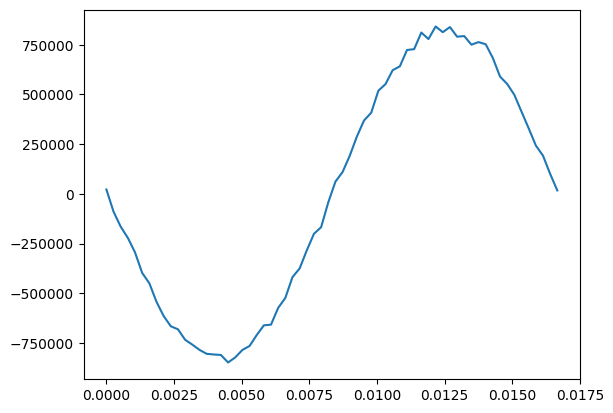

In [29]:
# Cambiar el índice [x, :, 0], para poder ver distintas señales
plt.plot(t, signals_prueba[5, :, 0])
